<a href="https://colab.research.google.com/github/PacoElizondo/ComputerVisionUPT/blob/main/Exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thresholding method

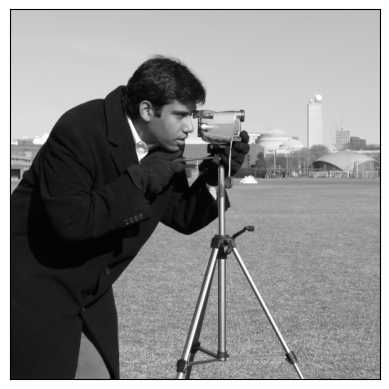

In [2]:
import skimage as sk
import matplotlib.pyplot as plt


img = sk.data.camera()
fig = plt.figure(), plt.xticks([]), plt.yticks([])
plt.imshow(img, cmap='gray')

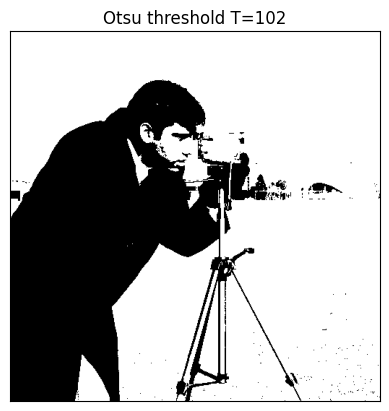

In [3]:
thresh = sk.filters.threshold_otsu(img)
fig = plt.figure(),  plt.xticks([]), plt.yticks([])
plt.imshow(img > thresh, cmap='gray')
plt.title('Otsu threshold T={}'.format(thresh))
plt.show()


Otsu separates the image in two classes: foreground and background.

For each possible threshold $ t ∈ [0,255] $, the pixels under the threshold correspond to one class and the pictures above to another.

The optimal threshold corresponds to the minimum intra-variance between the classes:

$
\sigma^2(t) = q_1(t) \sigma_1^2(t) + q_2(t) \sigma_2^2(t)
$

where $\sigma_i$ corresponds to the variance of class $i$ and $q_i$ to the probability of any pixel to be in class $i$

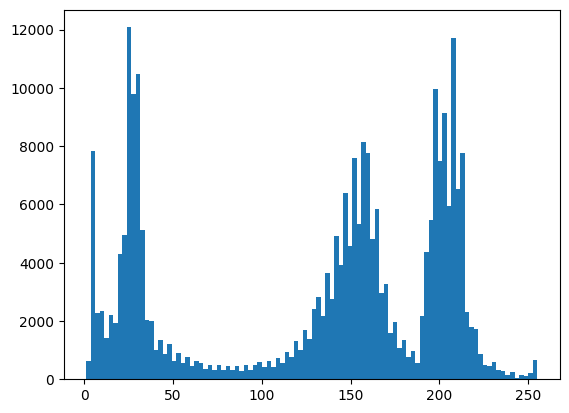

In [4]:
import numpy as np


fig = plt.figure()
img_array = img.flatten()
n = plt.hist(img_array, bins = 100, range = [1, img_array.max()])



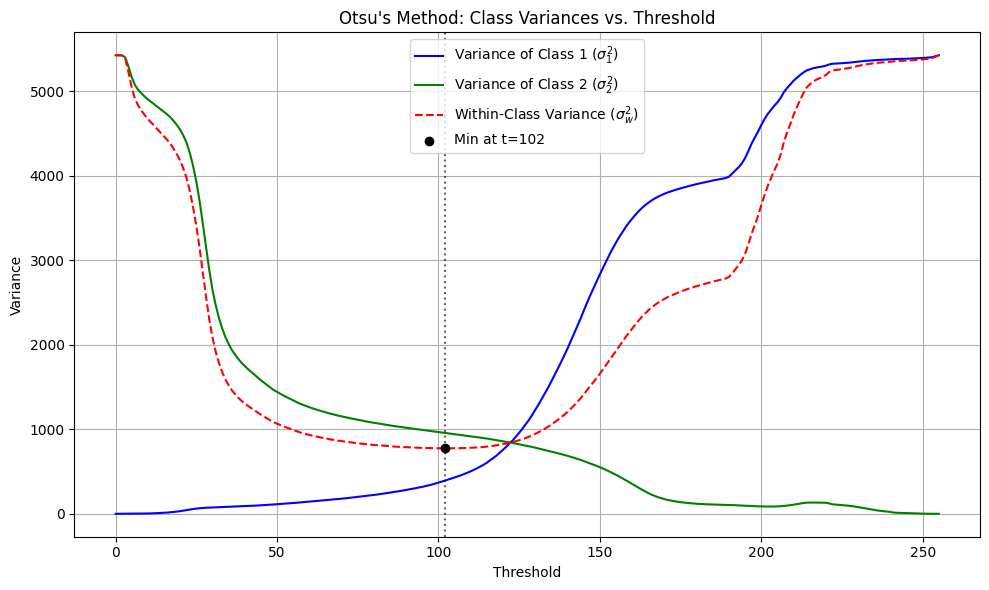

In [5]:


# Compute normalized histogram
hist, bin_edges = np.histogram(img, bins=256, range=(0, 256))
hist_norm = hist / hist.sum()

# Intensity levels
thresholds = np.arange(256)

# Class probabilities
q1 = np.cumsum(hist_norm)
q2 = 1 - q1

# Class means
mu_total = np.sum(thresholds * hist_norm)
mu1 = np.cumsum(thresholds * hist_norm) / (q1 + 1e-8)
mu2 = (mu_total - np.cumsum(thresholds * hist_norm)) / (q2 + 1e-8)

# Class variances
var1 = np.zeros(256)
var2 = np.zeros(256)

for t in thresholds:
    if q1[t] > 0:
        var1[t] = np.sum(((thresholds[:t+1] - mu1[t]) ** 2) * hist_norm[:t+1]) / q1[t]
    if q2[t] > 0:
        var2[t] = np.sum(((thresholds[t+1:] - mu2[t]) ** 2) * hist_norm[t+1:]) / q2[t]

# Within-class variance
sigma_w2 = q1 * var1 + q2 * var2
# Find Otsu's optimal threshold
optimal_t = np.argmin(sigma_w2)
min_variance = sigma_w2[optimal_t]

# Plot variances with a marker
plt.figure(figsize=(10, 6))
plt.plot(thresholds, var1, label='Variance of Class 1 ($\sigma_1^2$)', color='blue')
plt.plot(thresholds, var2, label='Variance of Class 2 ($\sigma_2^2$)', color='green')
plt.plot(thresholds, sigma_w2, label='Within-Class Variance ($\sigma_w^2$)', color='red', linestyle='--')
plt.scatter(optimal_t, min_variance, color='black', zorder=5, label=f'Min at t={optimal_t}')
plt.axvline(optimal_t, color='black', linestyle=':', alpha=0.6)

plt.xlabel('Threshold')
plt.ylabel('Variance')
plt.title("Otsu's Method: Class Variances vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Unsupervised Segmentation

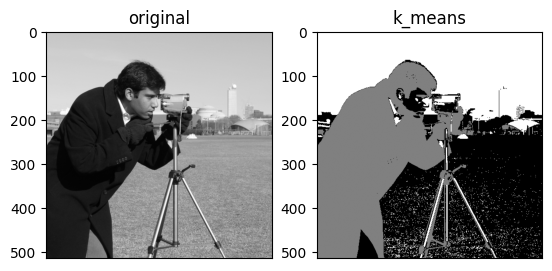

In [6]:
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans

v_img = np.reshape(img,(img.shape[0]*img.shape[1],1))
n_clus = 3
kmeans = KMeans(n_clus, random_state=0).fit(v_img)
v_kmeans = kmeans.predict(v_img)
img_kmeans = np.reshape(v_kmeans,(img.shape[0],img.shape[1]))

fig = plt.figure()
plt.subplot(1, 2, 1), plt.xticks([]), plt.xticks([])
plt.imshow(img, cmap='gray')
plt.title('original')
plt.subplot(1, 2, 2),  plt.xticks([]), plt.xticks([])
plt.imshow(img_kmeans, cmap='gray')
plt.title('k_means')

plt.show()

K_means groups pixels that are close to each other (by it's vectorial features) into a segment or cluster (as the starting point "clusters" similar pixels), i.e. a very dark pixel and a very light pixel will end up in different segments, in the case of an rgb image, clusters will be made upon close-to-each-other colors.

# Supervised Segmentation

In [7]:
from google.colab import drive
drive.mount('/content/drive')
import os

path = '/content/drive/MyDrive/MasterCourses/UPT/ComputerVision/'


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


I_train = sk.io.imread(os.path.join(path,'vessels_train.jpg'))
I_train_GT = sk.io.imread(os.path.join(path,'vessels_train_GT.tif'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Flatten the image and label
H, W = I_train.shape
X = I_train.reshape(-1, 1)
y = I_train_GT.reshape(-1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# Train a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1).fit(X_train, y_train)


In [20]:
# Predict labels for the test image
predicted_labels = classifier.predict(X)
segmented = predicted_labels.reshape(H, W)

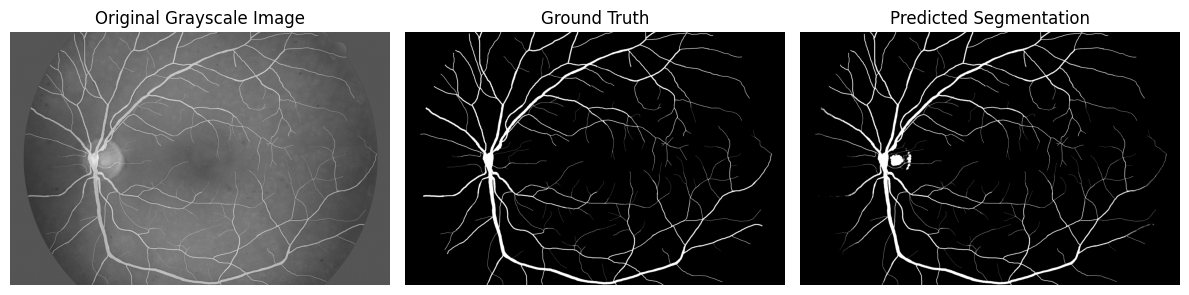

In [21]:
# Visualize results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original Grayscale Image")
plt.imshow(I_train, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(I_train_GT, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Segmentation")
plt.imshow(segmented, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()